In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import pyClientRLagentPytorch
import utils
from models import DifferentiablePhospheneSimulator,ThresholdedSobel, OrientedSobel, SurrogateCanny

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def state_to_phosphenes(raw_state, sigma, simulator):
    image_array = environment.state2usableArray(raw_state)
    grey_img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma)+1
    blurred = cv2.GaussianBlur(grey_img,(ksize,ksize),sigma) #cv2.GaussianBlur(grey_img,(35,35),10)#
    blurred = torch.tensor(blurred, device=device,dtype=torch.float).view(1,1,*blurred.shape)/255
    mask = sobel_net(blurred)
    phosphenes = simulator(mask)
    phosphenes = phosphenes.cpu().detach().numpy().squeeze()
    blurred = blurred.cpu().detach().numpy().squeeze()
    mask = mask.cpu().detach().numpy().squeeze()
    # normalize to the range 0-1
    #phosphenes /= 255.0
    return grey_img, blurred, mask,phosphenes

def state_to_phosphenes_canny_model(raw_state, sigma, simulator):
    image_array = environment.state2usableArray(raw_state)
    grey_img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma)+1
    blurred = cv2.GaussianBlur(grey_img,(ksize,ksize),sigma) #cv2.GaussianBlur(grey_img,(35,35),10)#
    blurred = torch.tensor(blurred, device=device,dtype=torch.float).view(1,1,*blurred.shape)/255
    mask = canny_net(blurred)
    phosphenes = simulator(mask)
    phosphenes = phosphenes.cpu().detach().numpy().squeeze()
    blurred = blurred.cpu().detach().numpy().squeeze()
    mask = mask.cpu().detach().numpy().squeeze()
    # normalize to the range 0-1
    #phosphenes /= 255.0
    return grey_img, blurred, mask,phosphenes

def state_to_phosphenes_oriented_sobel(raw_state, sigma, simulator):
    image_array = environment.state2usableArray(raw_state)
    grey_img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma)+1
    blurred = cv2.GaussianBlur(grey_img,(ksize,ksize),sigma) #cv2.GaussianBlur(grey_img,(35,35),10)#
    blurred = torch.tensor(blurred, device=device,dtype=torch.float).view(1,1,*blurred.shape)/255
    mask = oriented_net(blurred)
    print(mask.shape)
    phosphenes = simulator(mask)
    phosphenes = phosphenes.cpu().detach().numpy().squeeze()
    blurred = blurred.cpu().detach().numpy().squeeze()
    mask = mask.cpu().detach().numpy().squeeze()
    # normalize to the range 0-1
    phosphenes /= 255.0
    return grey_img, blurred, mask,phosphenes

def state_to_phosphenes_sobel_old_sim(raw_state, sigma, simulator_sobel):
    image_array = environment.state2usableArray(raw_state)
    grey_img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma+1).astype(int) # rule of thumb: choose k_size>3*sigma
    blurred = cv2.GaussianBlur(grey_img,(ksize,ksize),sigma)
    blurred = torch.tensor(blurred, device=device,dtype=torch.float).view(1,1,*blurred.shape)/255
    mask = sobel_net(blurred).cpu().detach().numpy().squeeze()
    phosphenes = simulator_sobel(activation_mask=mask)
    blurred = blurred.cpu().detach().numpy().squeeze()
    return grey_img, blurred, mask, phosphenes


def state_to_phosphenes_canny(raw_state, sigma, threshold_high, threshold_low, simulator_canny):
    image_array = environment.state2usableArray(raw_state)
    ksize = 11 #np.round(4*sigma+1).astype(int) # rule of thumb: choose k_size>3*sigma
    blurred = cv2.GaussianBlur(image_array,(ksize,ksize),sigma)
    canny = cv2.Canny(blurred,threshold_low,threshold_high)
    phosphenes = simulator_canny(activation_mask=canny)
    return image_array, blurred, canny, phosphenes

def state_to_phosphenes_canny_gray(raw_state, sigma, threshold_high, threshold_low, simulator_canny):
    image_array = environment.state2usableArray(raw_state)
    grey_img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    ksize = 11 #np.round(4*sigma+1).astype(int) # rule of thumb: choose k_size>3*sigma
    blurred = cv2.GaussianBlur(grey_img,(ksize,ksize),sigma)
    canny = cv2.Canny(blurred,threshold_low,threshold_high)
    phosphenes = simulator_canny(activation_mask=canny)
    return grey_img, blurred, canny, phosphenes

In [3]:
# Unity environment
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
timescale  = 1           # update step scale for unity
size = 128
screen_height = screen_width = size

environment = pyClientRLagentPytorch.Environment(ip = ip, port = port, size = size, timescale = timescale) 


In [4]:
end, reward, state_raw = environment.reset()
end, reward, state_raw = environment.reset_test()

In [5]:
end, reward, state_raw = environment.step(0)#forward

In [6]:
end, reward, state_raw = environment.step(1)#left

In [7]:
end, reward, state_raw = environment.step(2)#right

In [8]:
end, reward, state_raw = environment.step(1)#left
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(2)#right
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward

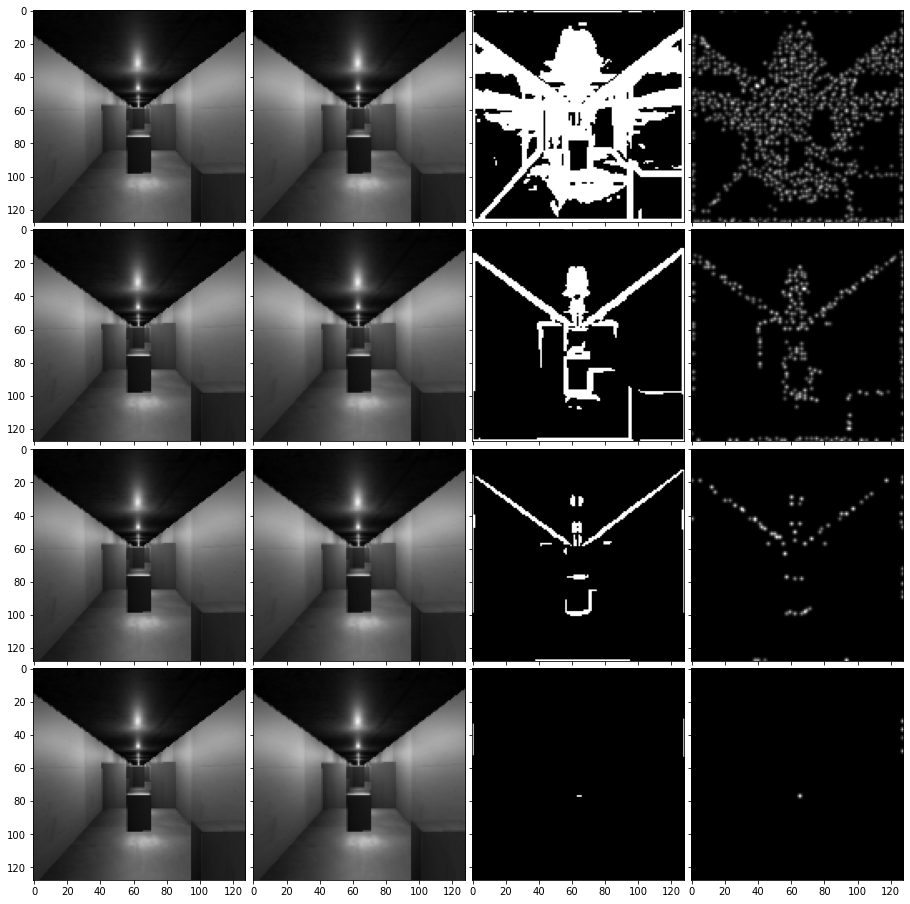

In [10]:
#test for different parameters
#end, reward, state_raw = environment.step(0)#forward
#parameters 
SIGMA = 0.4
phosphene_resolution= (42,42)
#intensity_var 0.8
#jitter 0.35
#intensity 15 not sure what it does anymore
#sigmaphosphenes 0.8

sobel_net = ThresholdedSobel(initial_threshold = 0.1, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
orig0, blur0,mask0, phos0= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 0.4, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
orig1, blur1,mask1, phos1= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 0.9, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
orig2, blur2, mask2, phos2= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 1.8, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
orig3, blur3, mask3, phos3= state_to_phosphenes(state_raw, SIGMA, simulator)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [orig0, blur0, mask0, phos0, orig1, blur1, mask1, phos1, orig2, blur2, mask2, phos2, orig3, blur3, mask3, phos3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()

In [11]:
# Unity environment
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
timescale  = 1           # update step scale for unity
size = 128
screen_height = screen_width = size

environment = pyClientRLagentPytorch.Environment(ip = ip, port = port, size = size, timescale = timescale) 


In [12]:
end, reward, state_raw = environment.reset()
end, reward, state_raw = environment.reset_test()
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(1)#left
end, reward, state_raw = environment.step(2)#right
end, reward, state_raw = environment.step(1)#left
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(2)#right
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward
end, reward, state_raw = environment.step(0)#forward

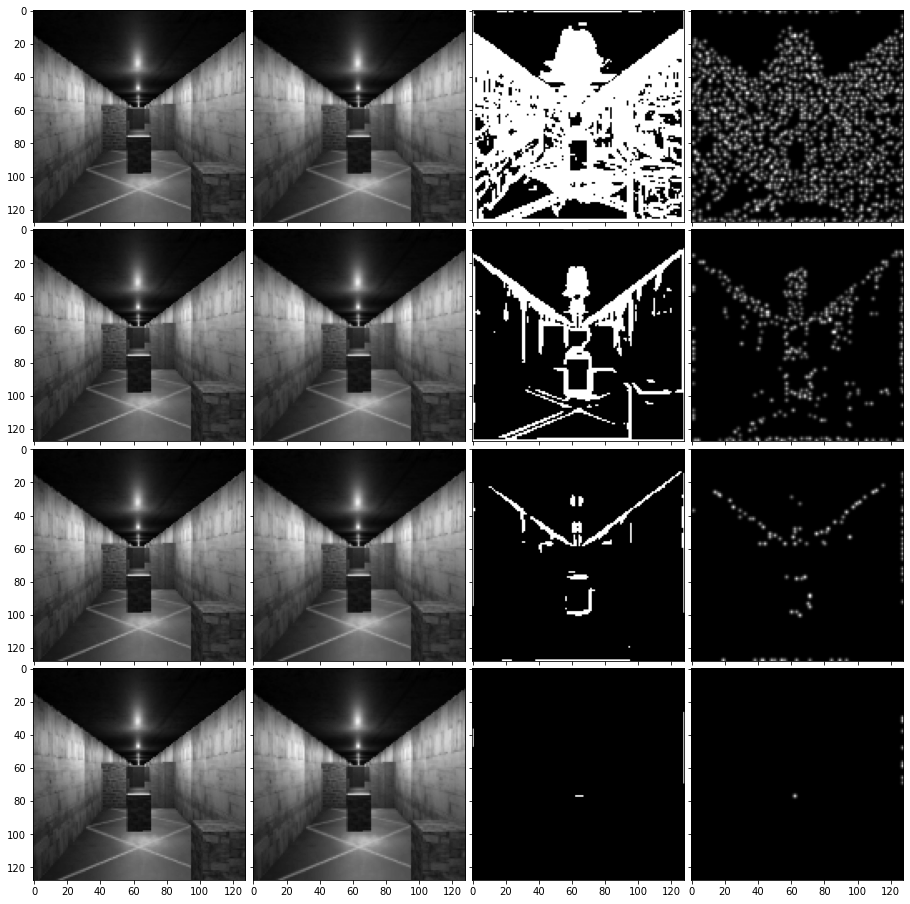

In [13]:

#test for different parameters
#end, reward, state_raw = environment.step(0)#forward
#parameters 
SIGMA = 0.4
phosphene_resolution= (42,42)
#intensity_var 0.8
#jitter 0.35
#intensity 15 not sure what it does anymore
#sigmaphosphenes 0.8

sobel_net = ThresholdedSobel(initial_threshold = 0.1, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
origcom0, blurcom0,maskcom0, phoscom0= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 0.4, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
origcom1, blurcom1,maskcom1, phoscom1= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 0.9, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
origcom2, blurcom2, maskcom2, phoscom2= state_to_phosphenes(state_raw, SIGMA, simulator)


sobel_net = ThresholdedSobel(initial_threshold = 1.8, k_size = 5, device = device).to(device)
simulator = DifferentiablePhospheneSimulator(phosphene_resolution=phosphene_resolution,size=(screen_height,screen_width),
        jitter=0.35, intensity_var=0.8, aperture=None, sigma=0.8, intensity=15,device = device) 
origcom3, blurcom3, maskcom3, phoscom3= state_to_phosphenes(state_raw, SIGMA, simulator)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [origcom0, blurcom0, maskcom0, phoscom0, origcom1, blurcom1, maskcom1, phoscom1, origcom2, blurcom2, maskcom2, phoscom2, origcom3, blurcom3, maskcom3, phoscom3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()

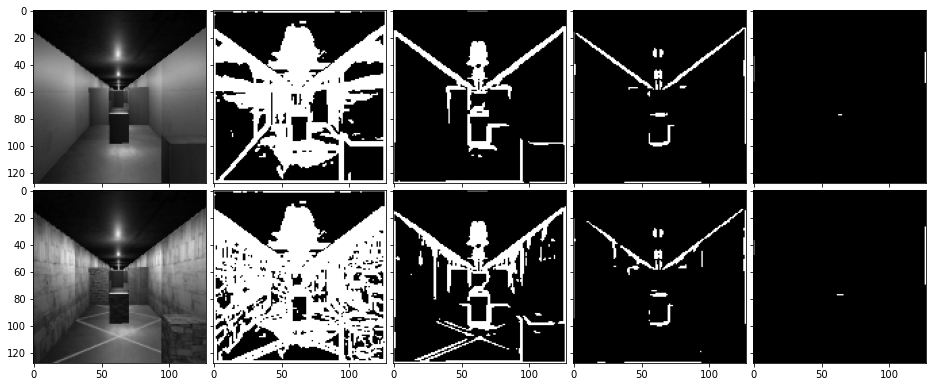

In [14]:
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [orig0, mask0, mask1, mask2, mask3, origcom0, maskcom0, maskcom1, maskcom2, maskcom3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

plt.show()